<a href="https://colab.research.google.com/github/thesstefan/vae_weather_translation/blob/main/notebooks/fog_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup

This is the section where datasets are chosen and notebook purpose is decided. 
Roughly, the notebook can be used for two main purposes:

*   Train new classification network, evaluate it and upload it to GDrive.
*   Download model from GDrive and evaluate it.

Specific parameters and values can be set by changing the constants accessible
at each step. 

This is mostly intended to be used for supervised classification tasks using transfer learning and **ResNet**. However, the model and its behavior can be easily changed.

In [111]:
import time
import copy
import os
import gdown
import tarfile
from datetime import datetime
from tqdm import tqdm
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch import nn

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision import datasets

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [113]:
WORK_DIR = '/content'

DATASET_NAME = 'fog_dataset'
DATASET_ARCHIVE_GDRIVE_URL = 'https://drive.google.com/file/d/1L3ea94NQ1SVQHG7Iv6UAy2m4BH1G6rxu/view?usp=share_link'
DATASET_DIR = os.path.join(WORK_DIR, DATASET_NAME)

MODEL_NAME = 'fog_net'
# GDrive URL to model to be used. If None, a new model is created.
MODEL_GDRIVE_URL = 'https://drive.google.com/file/d/1GOCXv655O7z-HB-kXFFn1iWo-Egg_Gb4/view?usp=share_link' 
# If the model is not being trained, no graphs are displayed.
TRAIN_MODEL = False 
# If True, model will be uploaded on GDrive at the end of the notebook
UPLOAD_MODEL = True

# Download Dataset

In [114]:
if not os.path.isdir(DATASET_NAME):
    archive_path = f'{DATASET_NAME}.tar.gz'

    if not os.path.exists(archive_path):
        gdown.download(DATASET_ARCHIVE_GDRIVE_URL, archive_path,
                       fuzzy=True, quiet=False)

    archive = tarfile.open(archive_path)
    archive.extractall(path=WORK_DIR)
    archive.close()

    os.remove(archive_path)

# Prepare Dataset and Data Loaders

In [115]:
RANDOM_AUGMENTATIONS = ([
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0)
])
RANDOM_AUGMENT_P = 0.5

BATCH_SIZE = 32
DATA_LOADER_WORKERS = 2

NORMALIZE_MEAN = (0.485, 0.456, 0.406)
NORMALIZE_STD = (0.229, 0.224, 0.225)

In [116]:
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomApply(RANDOM_AUGMENTATIONS, p=RANDOM_AUGMENT_P),
            transforms.ToTensor(),
            transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
        ]),
    'val':
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
        ]),
    'test':
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
        ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, 
                                               num_workers=DATA_LOADER_WORKERS)
                for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Define Model

In [117]:
FULLY_CONNECTED_LAYERS = lambda fc_inputs: nn.Sequential(
    nn.Linear(fc_inputs, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
#    nn.Dropout(0.4),
    nn.Linear(64, len(class_names)),
    nn.LogSoftmax(dim=1)
)

ADAM_LEARNING_RATE = 0.001
ADAM_BETAS = (0.9, 0.999)

SCHEDULER_STEP_SIZE = 25
SCHEDULER_GAMMA = 0.75

MODEL = models.resnet50
MODEL_WEIGHTS = models.ResNet50_Weights.IMAGENET1K_V1

USE_TRANSFER_LEARNING = True
NUM_EPOCHS = 100
UPLOAD_MODEL = True

In [118]:
model = MODEL(weights=MODEL_WEIGHTS)

if USE_TRANSFER_LEARNING:
    for param in model.parameters():
        param.requires_grad = False

fc_inputs = model.fc.in_features
model.fc = FULLY_CONNECTED_LAYERS(fc_inputs)

if MODEL_GDRIVE_URL:
    model_path = os.path.join(WORK_DIR, MODEL_NAME)
    gdown.download(MODEL_GDRIVE_URL, model_path, fuzzy=True, quiet=False)

    model.load_state_dict(torch.load(model_path, map_location=device))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=ADAM_LEARNING_RATE,
                       betas=ADAM_BETAS)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                             step_size=SCHEDULER_STEP_SIZE, 
                                             gamma=SCHEDULER_GAMMA)

Downloading...
From: https://drive.google.com/uc?id=1GOCXv655O7z-HB-kXFFn1iWo-Egg_Gb4
To: /content/fog_net
100%|██████████| 94.9M/94.9M [00:00<00:00, 189MB/s]


# Train Model

In [119]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    history = {
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        }
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(data_loaders[phase])
            loop.set_description(
                f'[{phase.upper()}] Epoch {epoch + 1} / {num_epochs}')
            for idx, (inputs, labels) in enumerate(loop):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                loop.set_postfix(loss=running_loss / dataset_sizes[phase],
                                 acc=float(running_corrects) / dataset_sizes[phase])

            if phase == 'train':
                scheduler.step()

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            history['loss'][phase].append(epoch_loss)
            history['acc'][phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training completed in {}m {}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return history, model

In [120]:
if TRAIN_MODEL:
    history, model = train_model(model, criterion, optimizer,
                                 exp_lr_scheduler, NUM_EPOCHS)

# Evaluate Model

In [121]:
if TRAIN_MODEL:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(range(1, NUM_EPOCHS + 1), history['loss']['train'],
             label='train')
    ax1.plot(range(1, NUM_EPOCHS + 1), history['loss']['val'],
             label='val')

    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    ax2.plot(range(1, NUM_EPOCHS + 1),
             [tensor.cpu() for tensor in history['acc']['train']],
              label='train')
    ax2.plot(range(1, NUM_EPOCHS + 1),
             [tensor.cpu() for tensor in history['acc']['val']],
             label='val')

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [122]:
def test_model():
    model.eval()
    correct = 0

    loop = tqdm(data_loaders['test'])
    loop.set_description('[TEST]')

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(acc=correct / dataset_sizes['test'])

In [123]:
test_model()

[TEST]: 100%|██████████| 13/13 [01:21<00:00,  6.29s/it, acc=0.93]


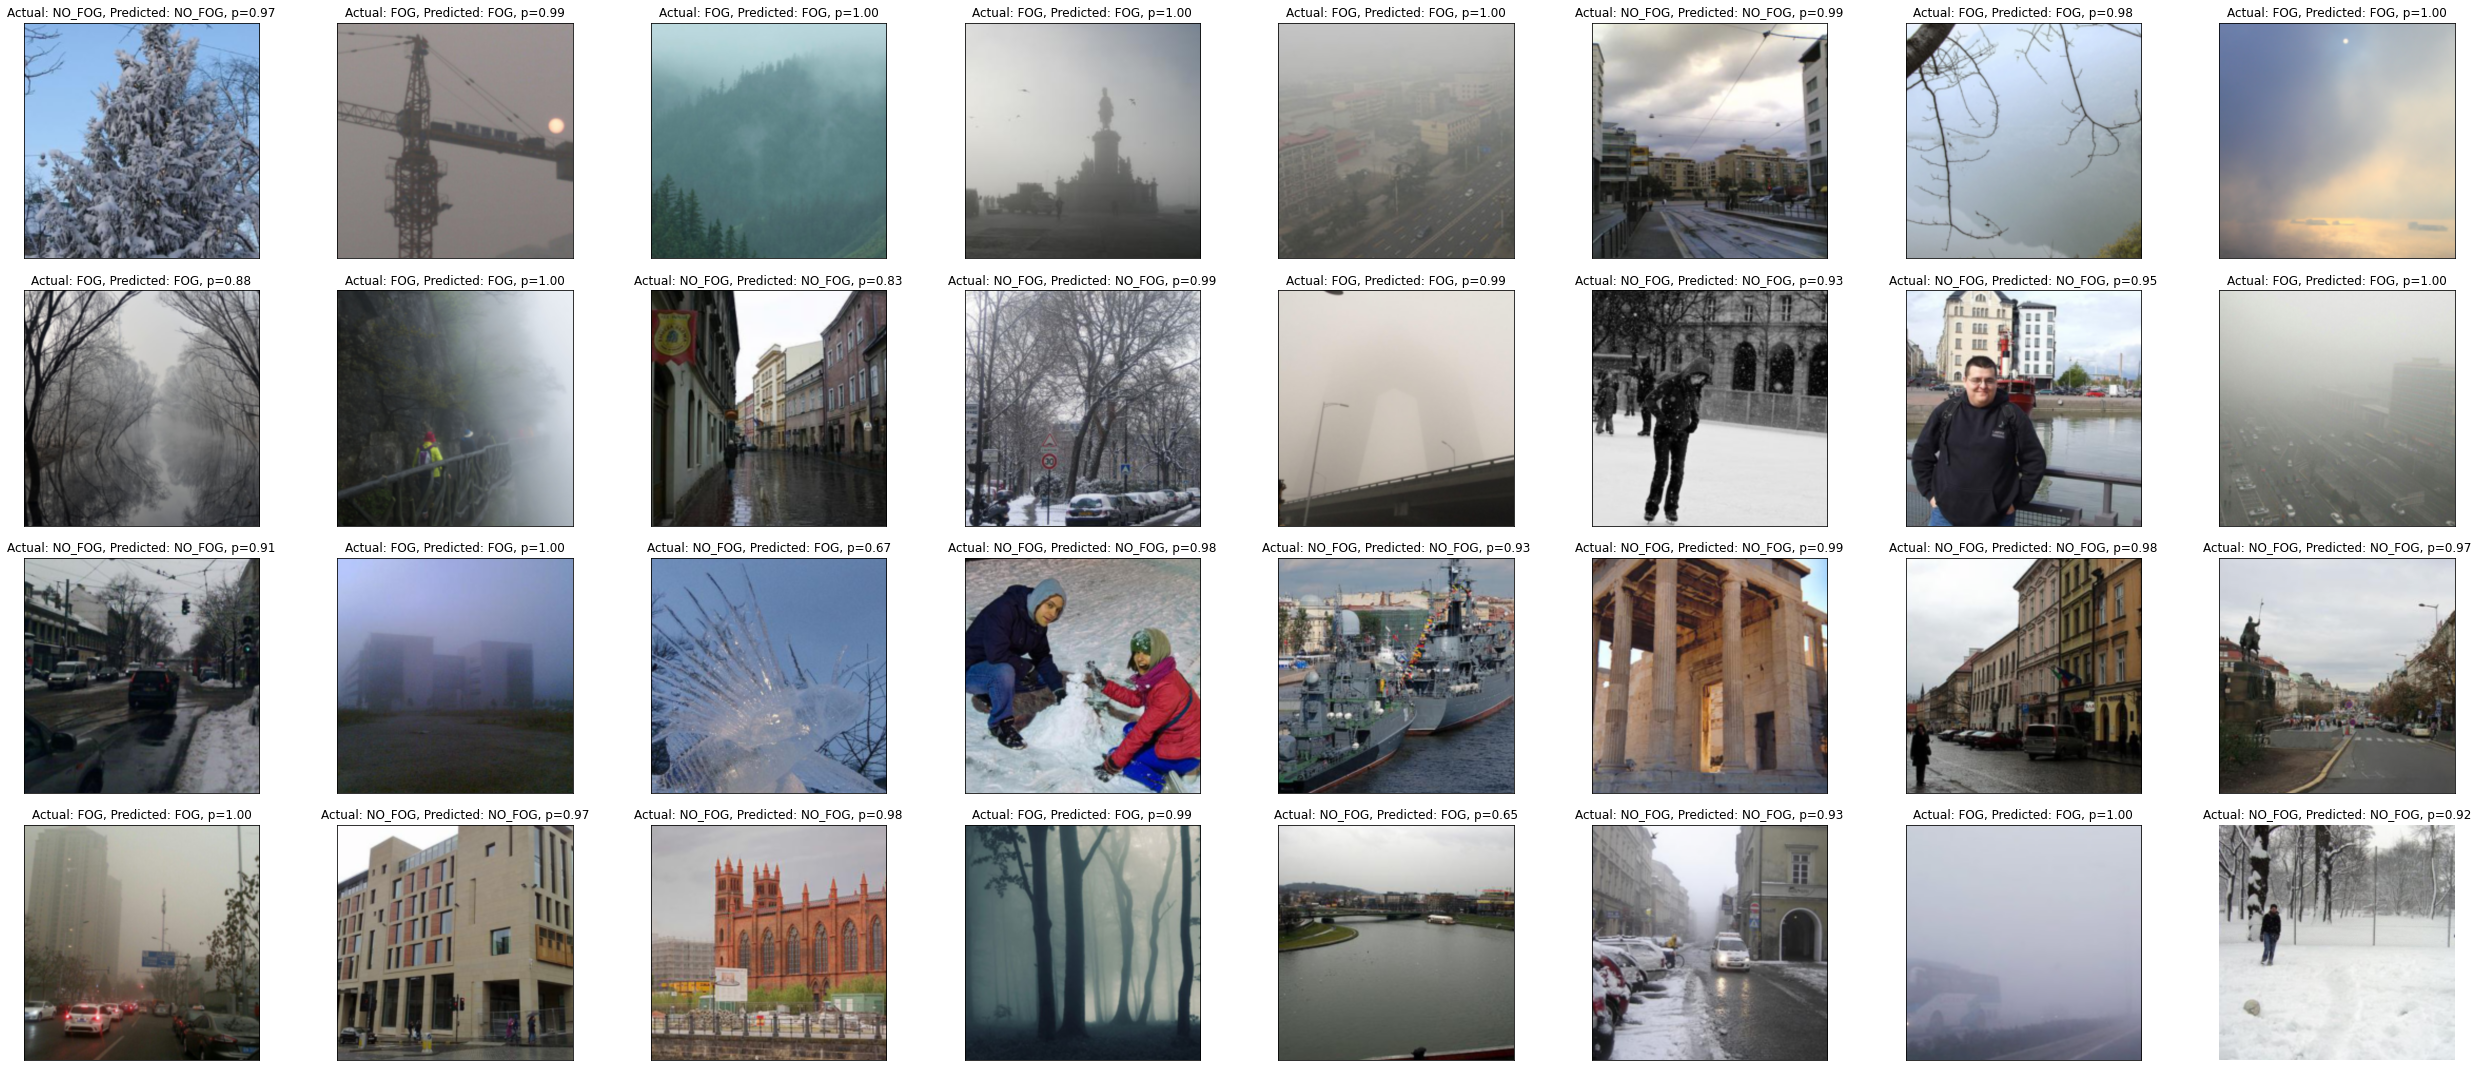

In [124]:
def inverse_normalize(tensor, 
                      mean=(0.485, 0.456, 0.406), 
                      std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

ROWS = 4
COLS = 8

rescale = transforms.Compose([transforms.Resize(2048)])
visualized_dataset = 'test'
classes = image_datasets[visualized_dataset].classes

fig, ax_array = plt.subplots(ROWS, COLS, figsize=(35, 15))
fig.subplots_adjust(wspace=2)
fig.tight_layout()

batch = next(iter(data_loaders[visualized_dataset]))

images, labels = batch
images, labels = images.to(device), labels.to(device)
outputs = model(images)

for index in range(data_loaders[visualized_dataset].batch_size):
    if index > ROWS * COLS:
        break

    denormalized = inverse_normalize(images[index])
    display_image = rescale(denormalized).permute(1, 2, 0)

    row_index = int(index / COLS)
    col_index = index % COLS
    ax_array[row_index, col_index].set_xticks([])
    ax_array[row_index, col_index].set_yticks([])
    ax_array[row_index, col_index].imshow(display_image.cpu())

    p = torch.nn.functional.softmax(outputs[index], dim=0)
    _, predicted = torch.max(p, 0)

    predicted_label = classes[predicted]
    ax_array[row_index, col_index].set_title(
        f'Actual: {classes[labels[index]]}, '
        f'Predicted: {predicted_label}, p={p[predicted]:.2f}')

plt.axis('off')
plt.show()

# Save and Upload Model

In [125]:
DRIVE_DIR = os.path.join('/gdrive/MyDrive', 'new_weathernet_models')

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_filename = f'{MODEL_NAME}_{current_time}'

if UPLOAD_MODEL:
    drive.mount('/gdrive')

    os.makedirs(DRIVE_DIR, exist_ok=True)

    torch.save(model.state_dict(), 
               os.path.join(DRIVE_DIR, model_filename))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
